# Assignment 1 - modelling of term deposit subscription

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

pd.set_option('display.expand_frame_repr', False)
pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

%run utilities.py
%run model_training.py


In [2]:
data=pd.read_csv("bank-additional-full.csv", sep=';')

In [3]:
print('Number of rows in data:')
print(data.shape[0])

print('Number of columns in data:')
print(data.shape[1])

Number of rows in data:
41188
Number of columns in data:
21


Distribution of target variable

no     0.887346
yes    0.112654
Name: y, dtype: float64

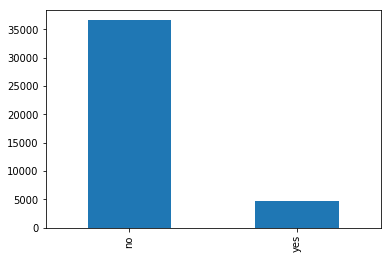

In [4]:
data['y'].value_counts(dropna=False).plot(kind='bar')
data['y'].value_counts(dropna=False)/data.shape[0]

In [5]:
data['y']=np.where(data['y']=='no',0,1)
target=data['y']
del data['y']
gc.collect()

2394

Detecting types of predictors(numerical x categorical)

In [6]:
preds=list(data)
num_preds, cat_preds = detect_types(data[preds])

Converting 'object' to 'category'

In [7]:
for col in cat_preds:
    data[col]=data[col].astype('category')

# Explanatory data analysis of categorical variables

Odds_ratio means log2 of ratio of target rate within given category and total target rate of dataset. For Example, when target rate in dataset is 0.05 and target rate within particular category is 0.1, than odds_ratio = log2(0.1/0.05)=1. 

job


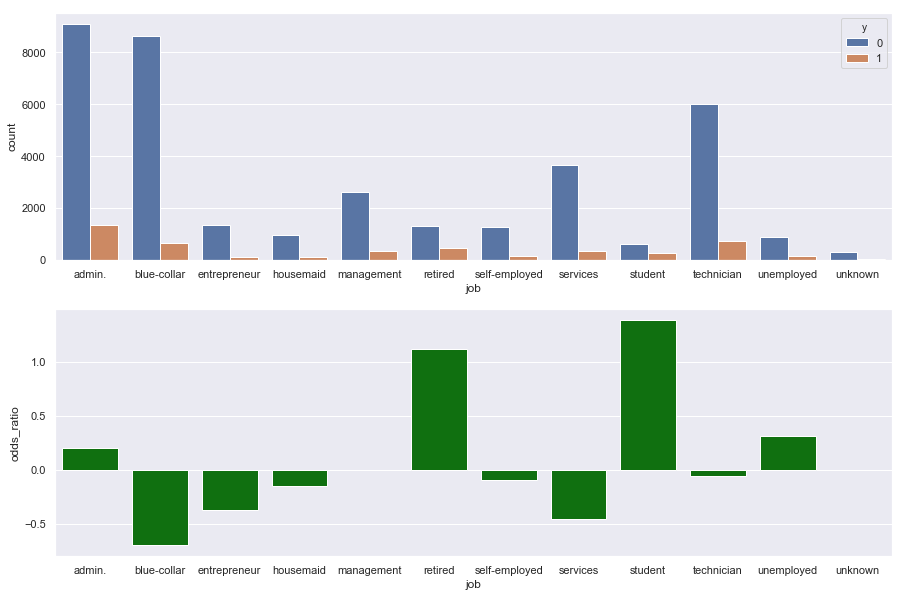

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------
marital


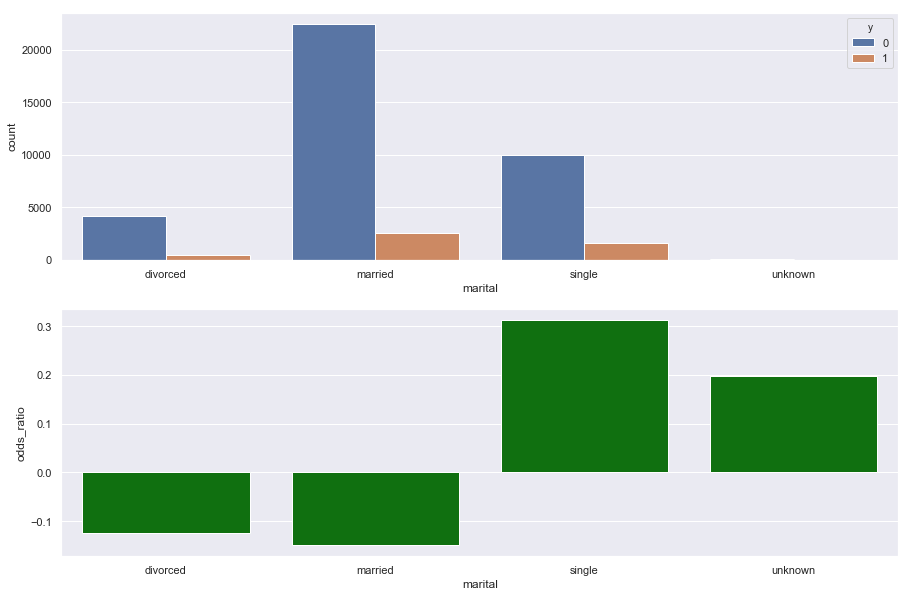

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------
education


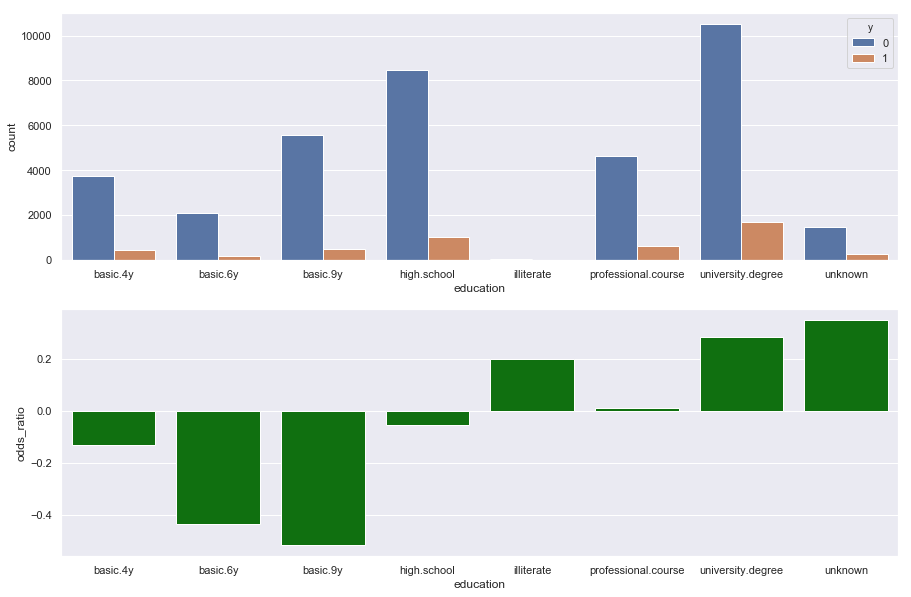

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------
default


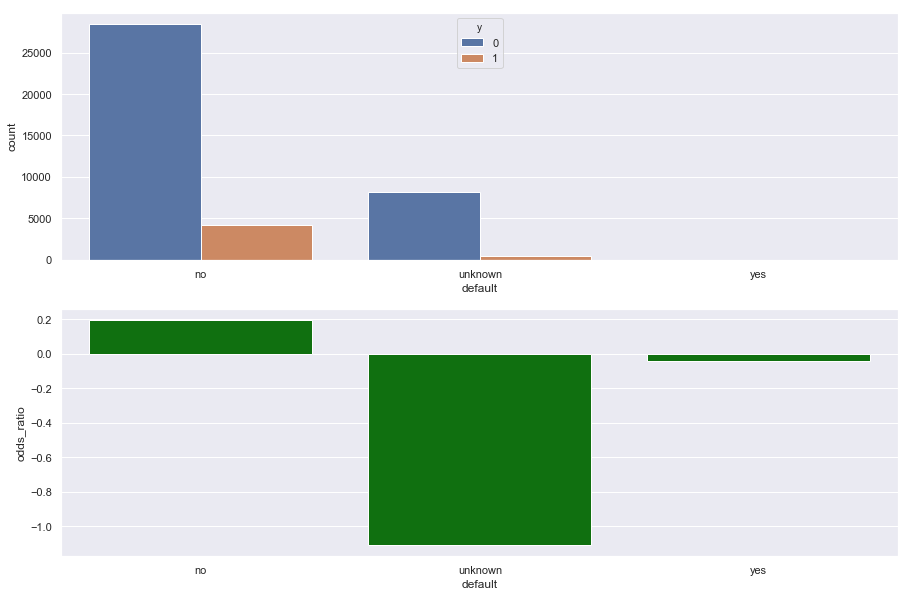

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------
housing


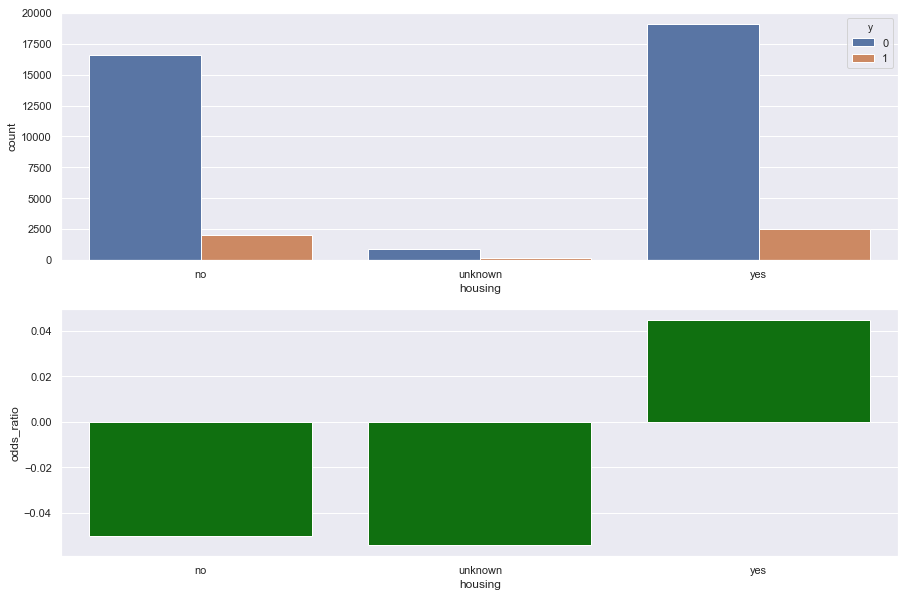

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------
loan


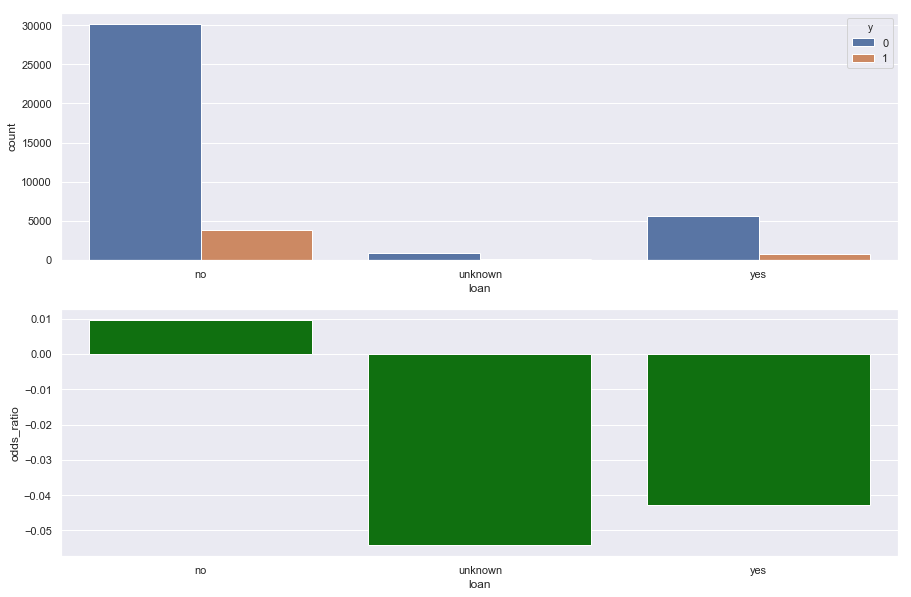

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------
contact


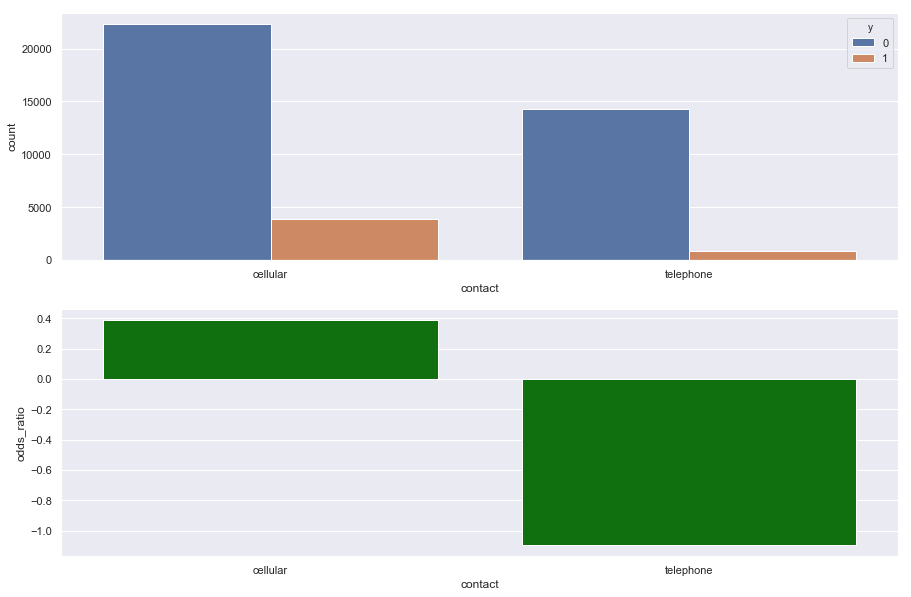

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------
month


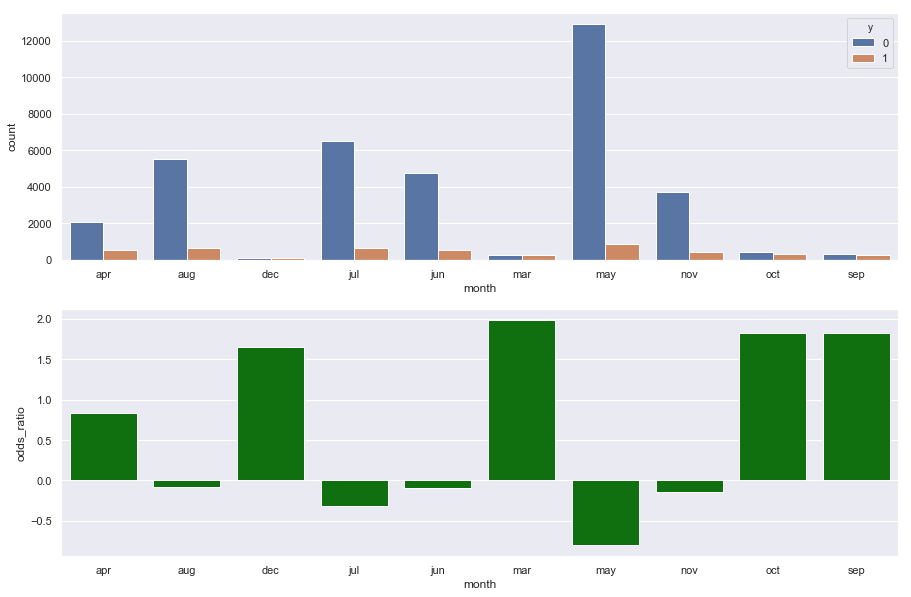

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------
day_of_week


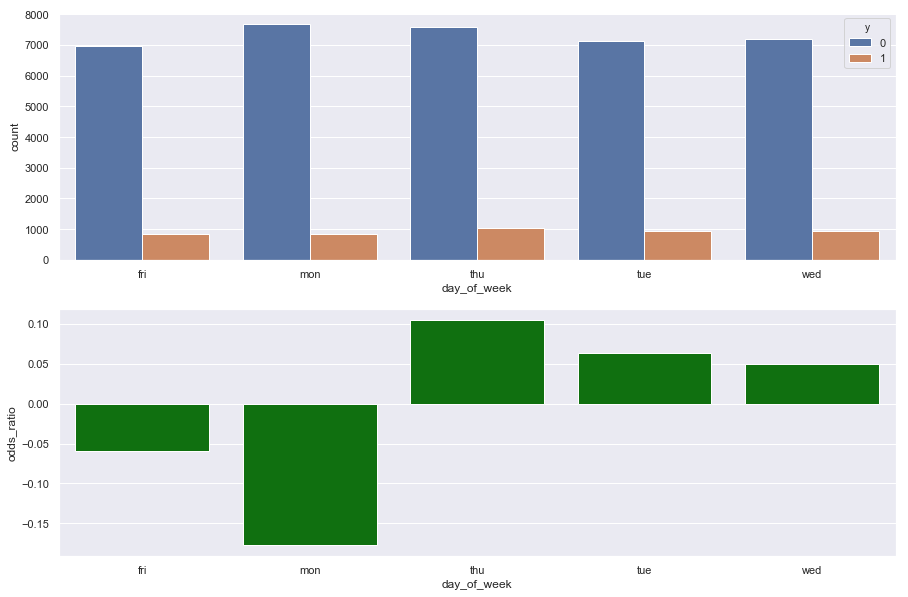

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------
poutcome


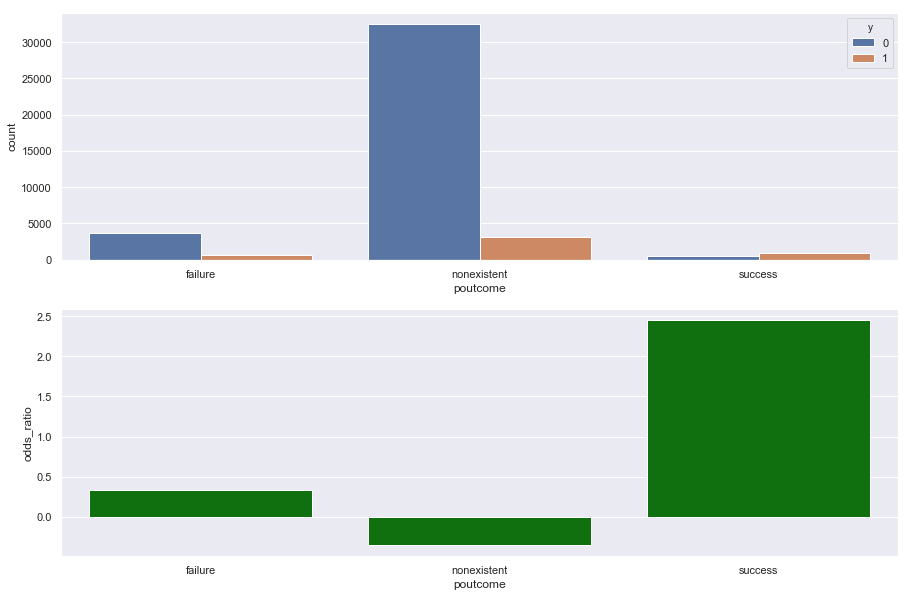

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------


In [8]:
for i in cat_preds:
    print(i)
    graph_exploration(data[i],target)
    
    print('--------------------------------------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------------------------------------')

Findings from EDA of categorical variables:  
* job : Categories with above average level of subscribers are students and retired. On the other hand blue-collar and services are not so much into subscribe. Looks like strong variable.

* marital: Single people are more for subscribing.

* Education: With higher education is the amount of subscribers higher.

* Default: Unknown category is strongly against subscribing.

* Housing: Does not look like promissing variable.

* Loan: Same situation as housing.

* Contact: Cellular contacts are more for subscribing.

* Month: Most of the contacts was in May, where the target rate was lowest. On the other hand October, September and March have much higher ratio of subscribers.

* Day of week: Does not look strong.

* Poutcome: Successful contacts are strongly invoking positive target.

# Explanatory data analysis of numerical variables

age
SAME FREQUENCY BINNING:


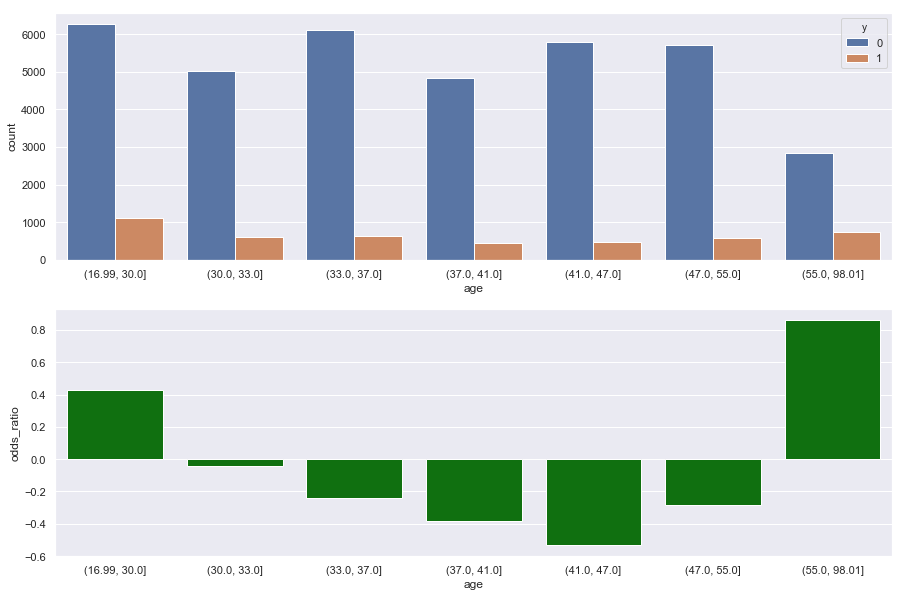

AUC of this variable:
0.511
---------------------------------------------------------
---------------------------------------------------------
duration
SAME FREQUENCY BINNING:


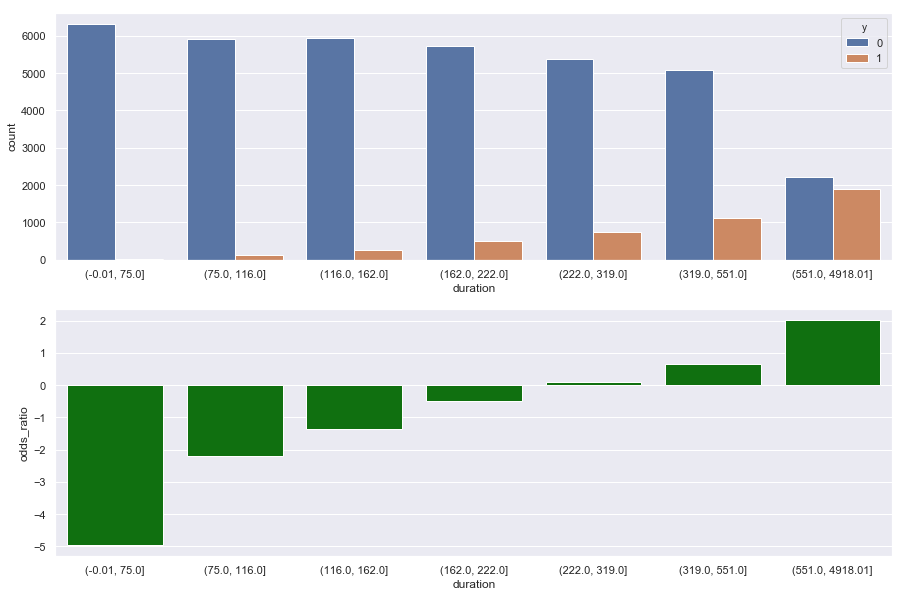

AUC of this variable:
0.818
---------------------------------------------------------
---------------------------------------------------------
campaign
SAME FREQUENCY BINNING:


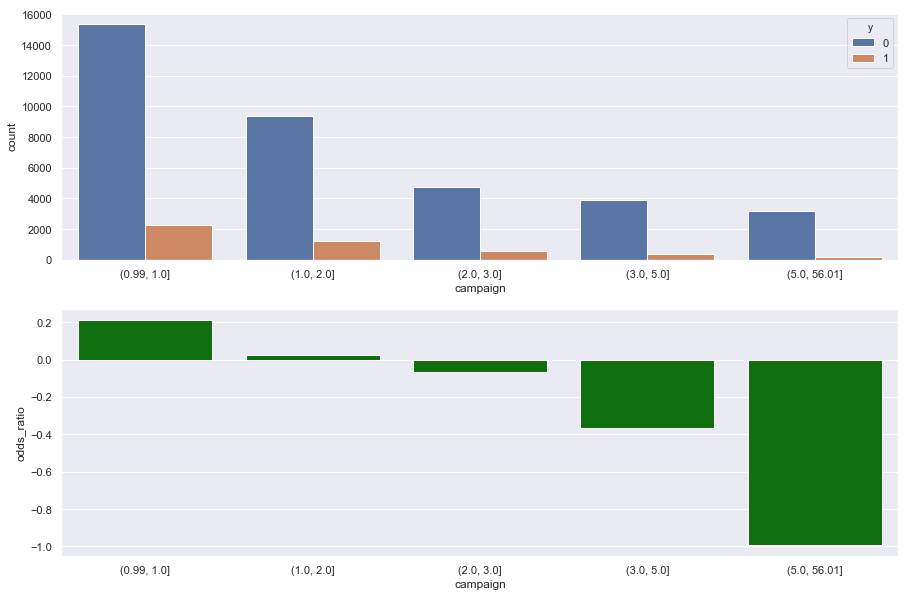

AUC of this variable:
0.555
---------------------------------------------------------
---------------------------------------------------------
pdays
SAME FREQUENCY BINNING:


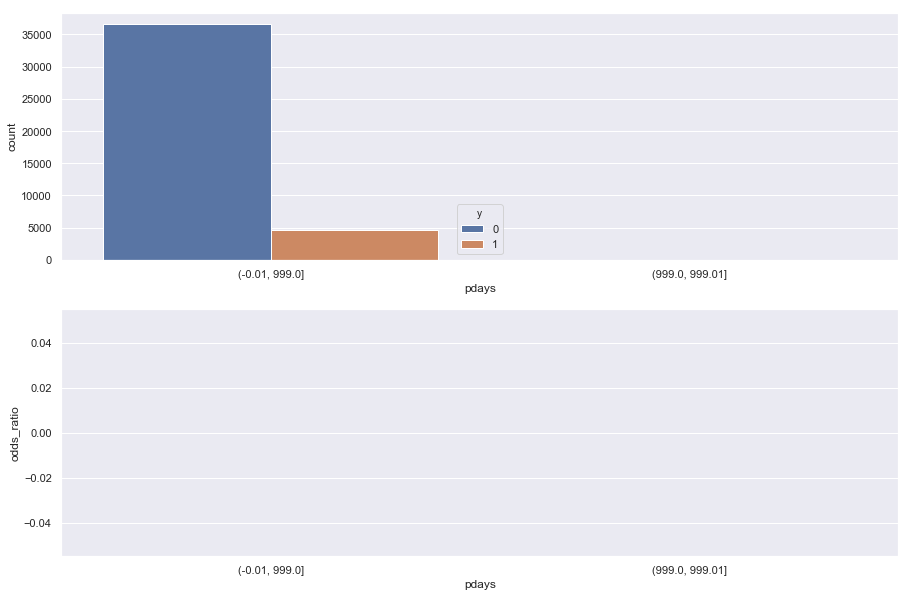

AUC of this variable:
0.597
---------------------------------------------------------
---------------------------------------------------------
previous
SAME FREQUENCY BINNING:


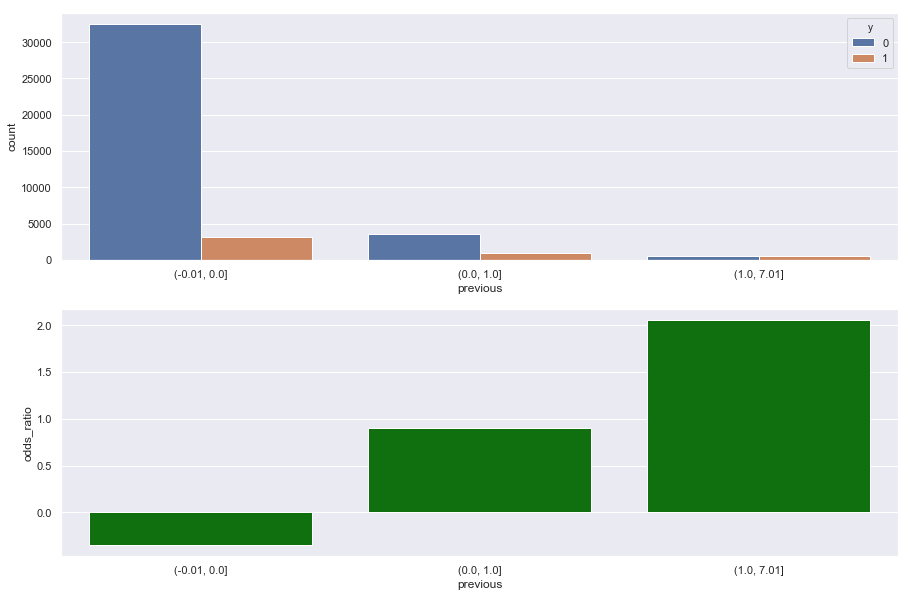

AUC of this variable:
0.609
---------------------------------------------------------
---------------------------------------------------------
emp.var.rate
SAME FREQUENCY BINNING:


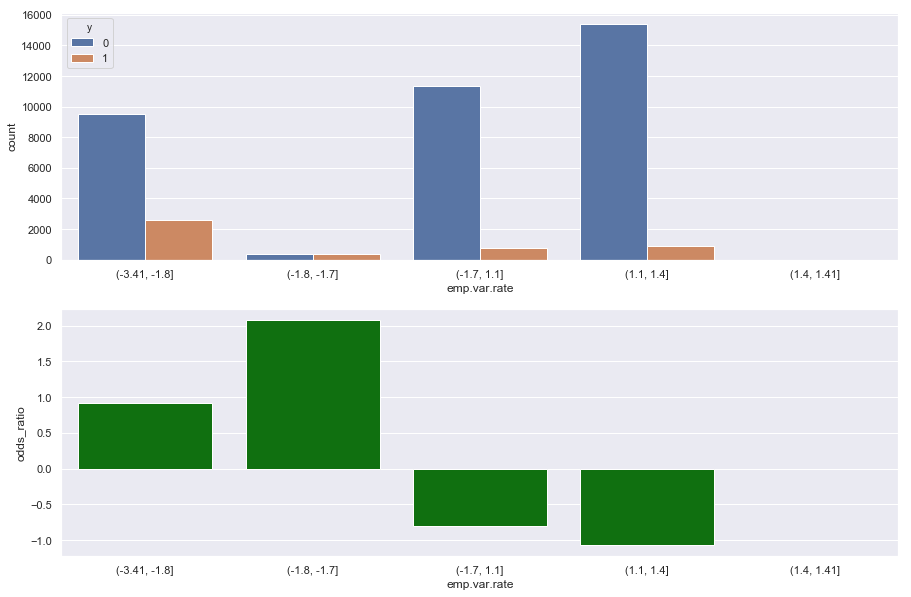

AUC of this variable:
0.717
---------------------------------------------------------
---------------------------------------------------------
cons.price.idx
SAME FREQUENCY BINNING:


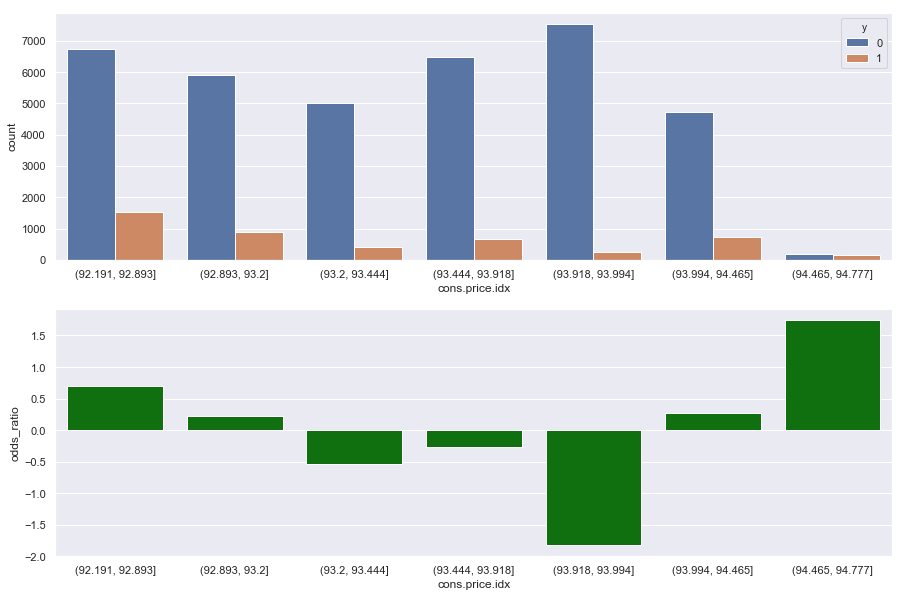

AUC of this variable:
0.611
---------------------------------------------------------
---------------------------------------------------------
cons.conf.idx
SAME FREQUENCY BINNING:


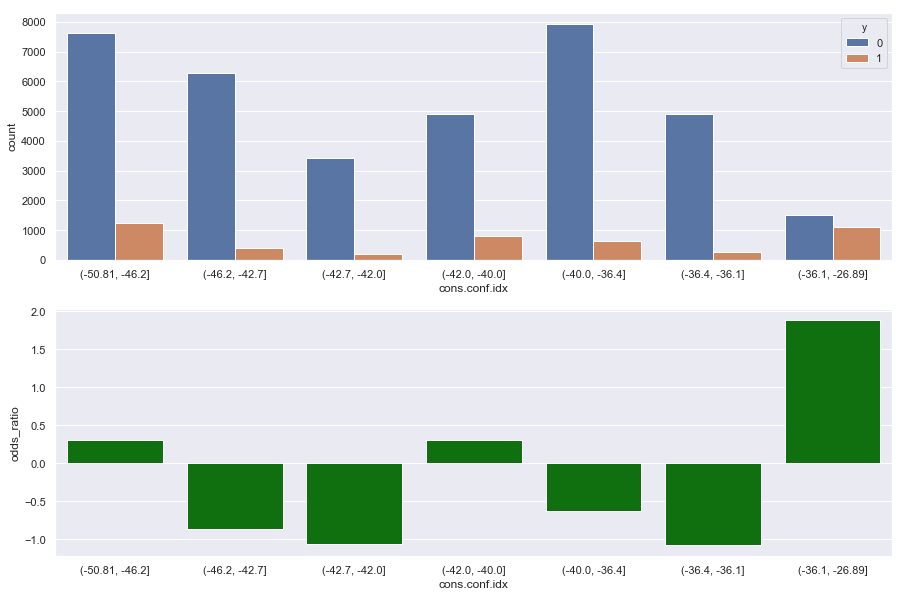

AUC of this variable:
0.537
---------------------------------------------------------
---------------------------------------------------------
euribor3m
SAME FREQUENCY BINNING:


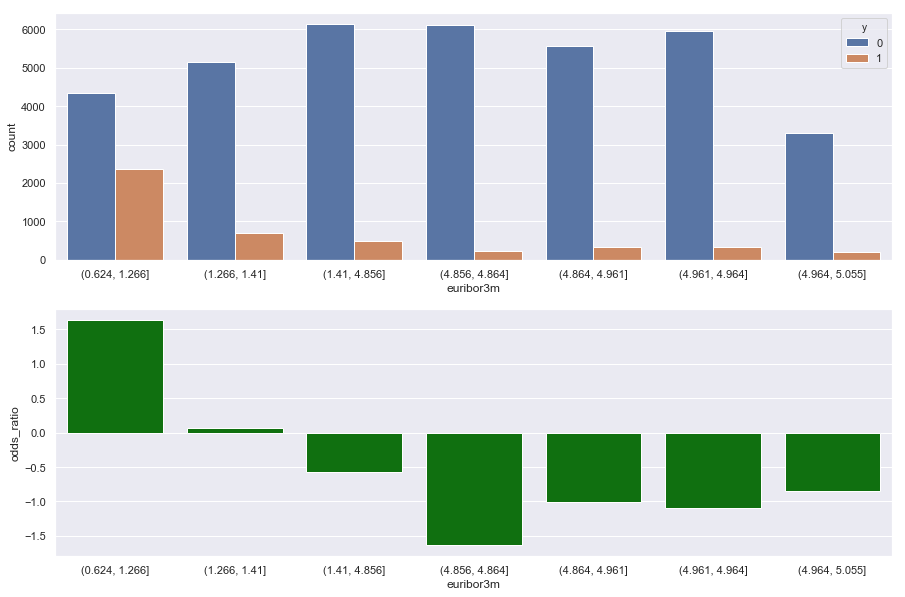

AUC of this variable:
0.743
---------------------------------------------------------
---------------------------------------------------------
nr.employed
SAME FREQUENCY BINNING:


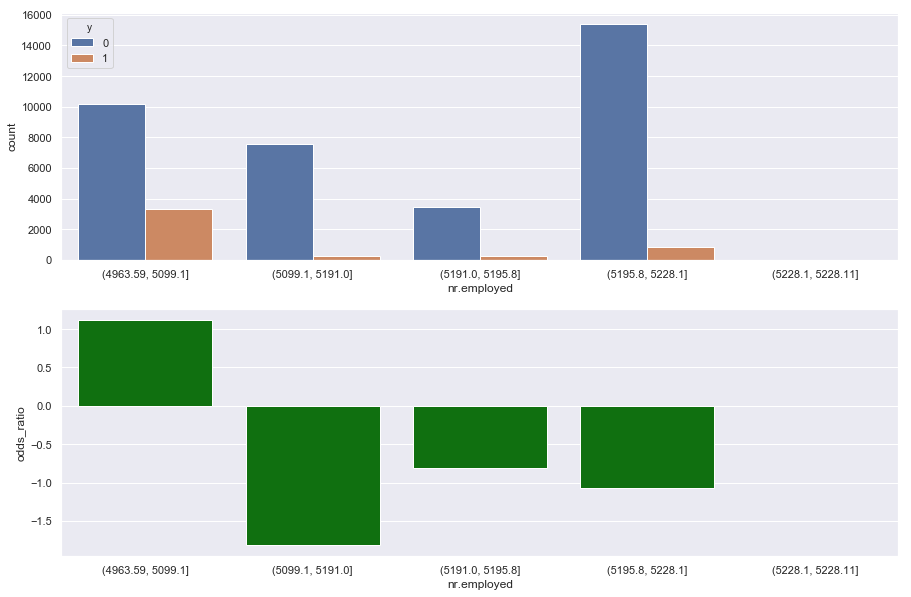

AUC of this variable:
0.749
---------------------------------------------------------
---------------------------------------------------------


In [9]:
for i in num_preds:
    print(i)
    
    print('SAME FREQUENCY BINNING:')
    
    borders=[]
    for j in [15,30,45,60,75,90]:
        borders=np.append(borders,np.nanpercentile(data[i],j))
    borders=np.concatenate(([data[i].min()-0.01], borders))
    borders=np.append(borders,data[i].max()+0.01)
    borders=list(dict.fromkeys(borders))
    graph_exploration(pd.cut(data[i],borders),target)
    
    print('AUC of this variable:')
    auc=comp_auc(target, data[i])
    if auc > 0.5:
        print(round(auc,3))
    else:
        print(round(1-auc,3))
    
    print('---------------------------------------------------------') 
    print('---------------------------------------------------------')

## Findings from EDA of numerical variables:
* Age is quadratic predictor.
* Duration is extremely strong predictor, where short contacs almost denying subscription.
* Higher number of campaigns has negative impact to the subsription.
* This automatical EDA does not tell us much about Pdays.
* Higher number of previous campaigns has positive impact to the subsription.
* Euribor3m and Nr.employed looks like strong variables

# LGBM Fitting

LGBM is newer implementation of famous XGBoost algorithm. Trained model is ensemble of many decision trees (usually), where every next decision tree is trained with (pseudo)residuals as a target variable from previous decion trees. Final prediction is then made as average of these decision trees.

LGBM implementation has few advantages over XGBoost - it can handle categorical variables implicitly (you do not need OHE), training of the model is much faster, etc. The results are usually pretty similar. 

Fitting of decision trees requires less data preparation than for example logistic regression, where linear relationship between target and variables is demanded. For example I do not have to care about quadratic relationship between age and target, because decision trees can handle it pretty fine. Therefore I do not need to care much about data preprocessing right now (i am not saying, that is never necessary). Next big advantage of decion trees is that in a similar way as nonlinearity implicitely finds interactions between variables. In the linear models you will never find interactions, unless you will create them manually. 

Disadvantage of these algorithms is that they are often harder to explain then linear models, where the whole model can be written as equation.

I will split my dataset to the 3 sets - train, validation and test. Train will be used for training. Validation will be used as a training stopper and finally test will be used as an untouched set for estimation of model's performance.

In [10]:
train, test, y_train, y_test = train_test_split( data, target, test_size=0.25, random_state=134)
train, valid, y_train, y_valid = train_test_split( train, y_train, test_size=0.3333, random_state=134)

In [11]:
print(train.shape)
print(valid.shape)
print(test.shape)

(20595, 20)
(10296, 20)
(10297, 20)


Algorithm will be used with pretty much default parameters.

In [12]:
params={'early_stopping_rounds': 100,
        'learning_rate': 0.05,
        'metric': 'auc',
        'objective': 'binary',
        'seed': 1234, 
        'verbose': 1}

After few iterations, I decided to not include predictors
'loan', 'housing', 'marital','previous', 'default', 'duration', 'education', 'emp.var.rate', 'job'
to the model, because it did not impact performance of my model.

Predictors that I used in the model are:
'day_of_week', 'age', 'contact', 'month', 'campaign', 'pdays', 'poutcome', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'

Questinable is using of variable 'Duration' in the model, because as it is written in the description, literally:
'Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model'.
Therefore I decided to remove it from the modelling part. When I tried to use it, it was the strongest variables and pushed the performance of the model up to the 0.95 AUC.

In [13]:
preds=['day_of_week', 'age', 'contact', 'month', 'campaign', 'pdays', 'poutcome', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [15]:
models = fit_model(train,y_train, valid, y_valid, params, preds)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.815182
Performance on validation sets:
[0.8151824043405808]
Mean:
0.8151824043405808


Comparing of ROC Curves on train,valid and test sets.

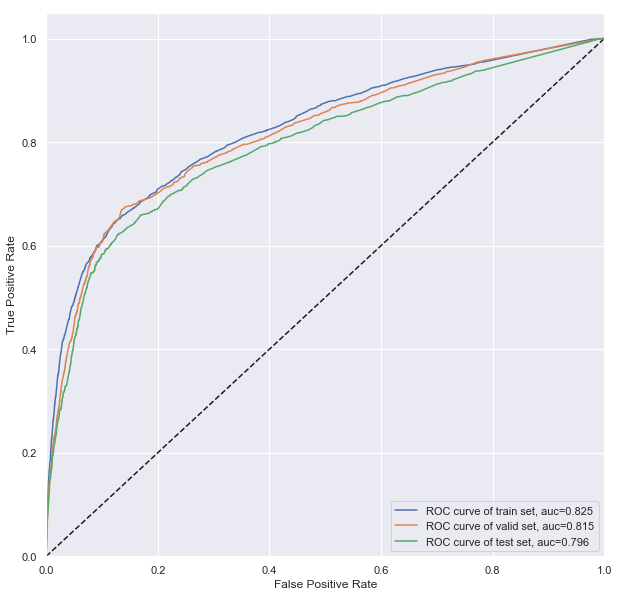

In [16]:
prepare_roc()


fpr, tpr, _ = roc_curve(y_train, predict(models, train, preds))
auc=roc_auc_score(y_train, predict(models, train, preds))
plt.plot(fpr, tpr, label = 'ROC curve of train set, auc={}'.format(round(auc,3)))
plt.legend(loc="lower right")
    
fpr, tpr, _ = roc_curve(y_valid, predict(models, valid, preds))
auc=roc_auc_score(y_valid, predict(models, valid, preds))
plt.plot(fpr, tpr, label = 'ROC curve of valid set, auc={}'.format(round(auc,3)))
plt.legend(loc="lower right")
    
fpr, tpr, _ = roc_curve(y_test, predict(models, test, preds))
auc=roc_auc_score(y_test, predict(models, test, preds))
plt.plot(fpr, tpr, label = 'ROC curve of test set, auc={}'.format(round(auc,3)))
plt.legend(loc="lower right")
    
plt.show()

It is quite common that performance of gradient boosting models is higher on the train set than on the validation and test set. And it does not mean that model is overfited.
So the performance of the training set is not anything that we have to care about. Important is performance on the untouched sample, which is almost AUC 0.8. 


## Model diagnostics 

### Variable importance - gain.

Gain importance denotes which predictor caused the biggest drop of loss function.

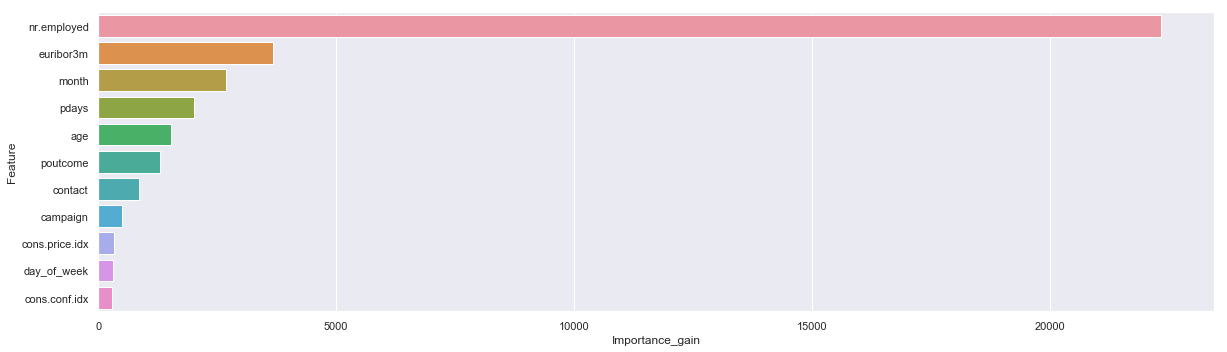

In [17]:
plot_importance(models, 'Importance_gain', preds ,ret=False, show=True, n_predictors = len(preds))

Most important predictor in model seems to be 'nr.employed'.

### Model diagnostics using SHAP values

Shap values is superpowerful method that gives us contribution to the predicted outcome of each variable for every single observation.
Therefore it brings local interpretability to every prediction and makes this model less 'black-box'.

Variables are sorted according their mean absolute impact on the prediction. And the SHAP value on x-axis means difference contribution to the prediction - average prediction in logits.

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[44]	valid_0's auc: 0.813556


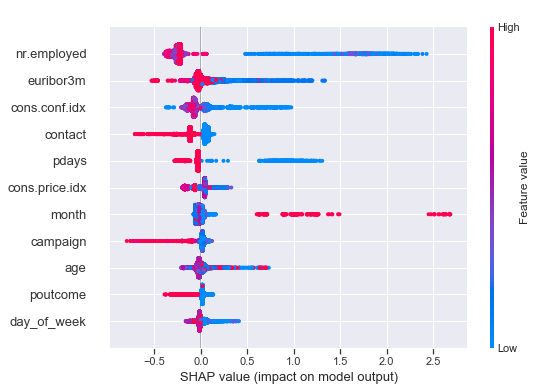

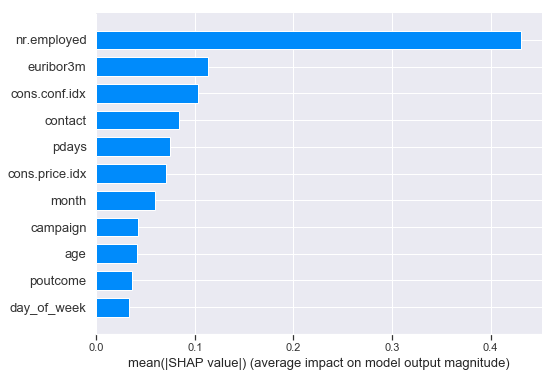

In [19]:
cat_preds=['day_of_week','contact','month','poutcome']
te_shap, shap_values ,explainer = print_shap_values(preds, num_preds, cat_preds, train, y_train, valid, y_valid, params)

SHAP dependence plot shows real relation between variable and prediction and with this tool one can check that the variable in the model.
behaves similarly that is expected for example from EDA. 

day_of_week


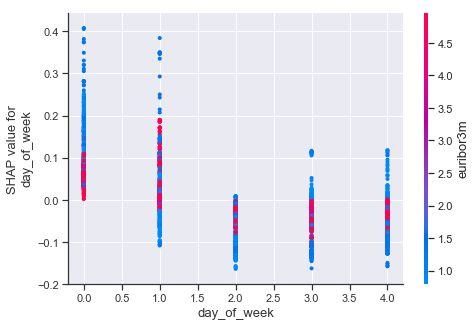

age


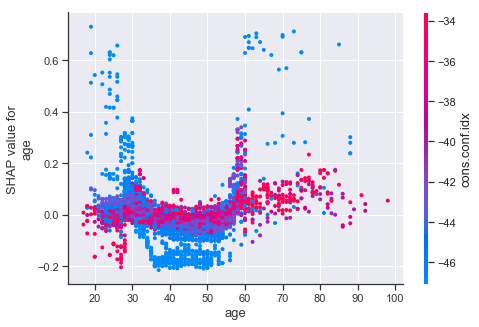

contact


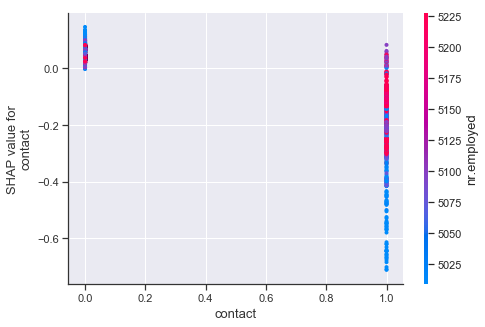

month


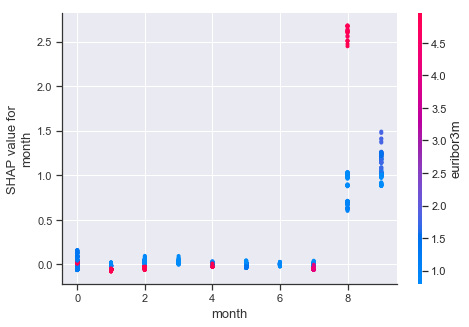

campaign


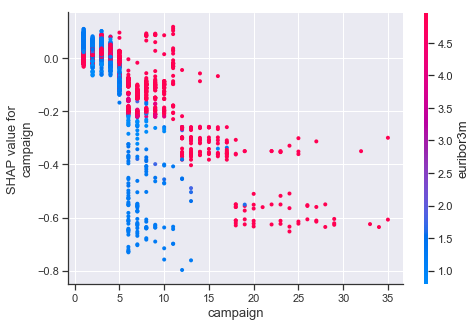

pdays


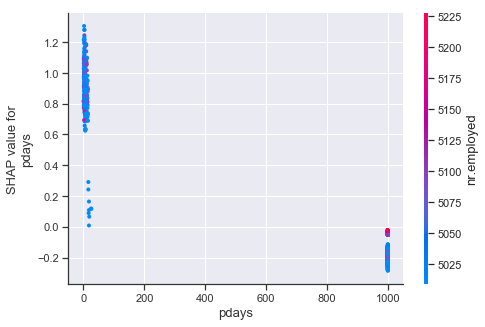

poutcome


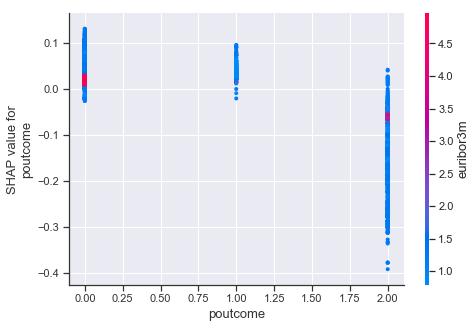

cons.price.idx


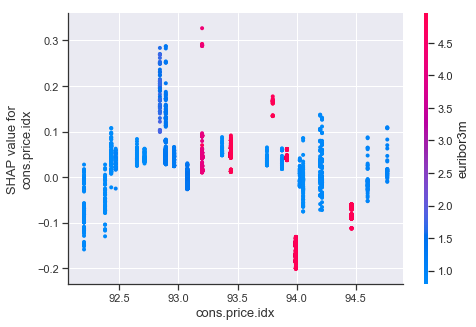

cons.conf.idx


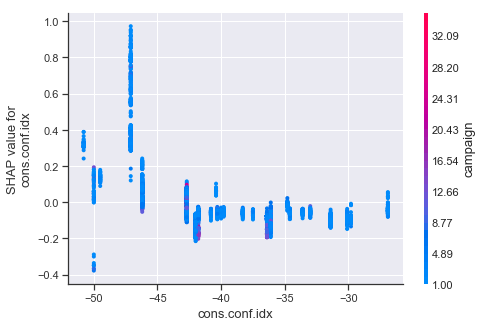

euribor3m


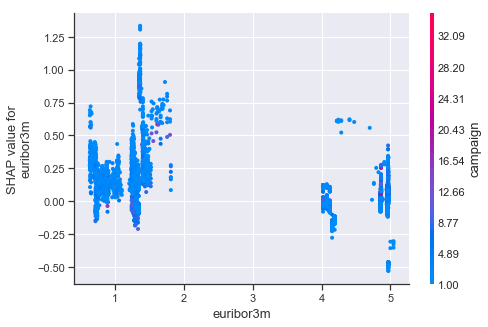

nr.employed


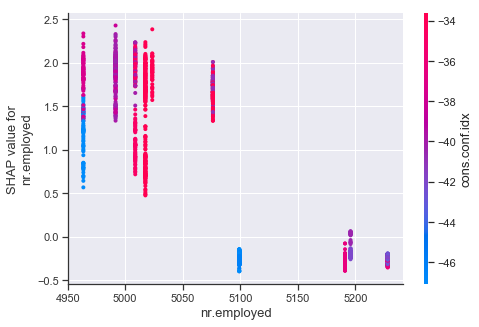

In [20]:
for i in preds:
    print(i)
    shap_dependence_plot(te_shap, cat_preds, shap_values, i, y=None)

There is nothing very surprising in these particular dependence plots.
The Age variable interacts with cons.conf.idx and Campaign interacts with euribor3m.
Important is that none of the variables behaves strangely or completely differently than in EDA.

# Fitting of Random Forest

Random forest is in the same ensemble of independently constructed decision trees. Final prediction is consequently made as average from particular trees.

I will use implementation from sci-kit learn library. Unfortunatelly, RF can't handle categorical features implicitely (LGBM does), so I have to use one hot encoding transformation.

I will restrict set of the predictors on the predictors, that were used for LGBM construction and consequently I will use same spliting of data for the sake of comparability of both models.

In [21]:
data_dummy=pd.get_dummies(data[preds], dummy_na=False)

In [22]:
train_dummy, test_dummy, y_train_dummy, y_test_dummy = train_test_split( data_dummy, target, test_size=0.25, random_state=134)
train_dummy, valid_dummy, y_train_dummy, y_valid_dummy = train_test_split( train_dummy, y_train_dummy, test_size=0.3333, random_state=134)

Fitting of model

In [23]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=1000, max_depth=4, random_state=0)
forest.fit(train_dummy, y_train_dummy)

RandomForestClassifier(max_depth=4, n_estimators=1000, random_state=0)

Printing of ROC curves

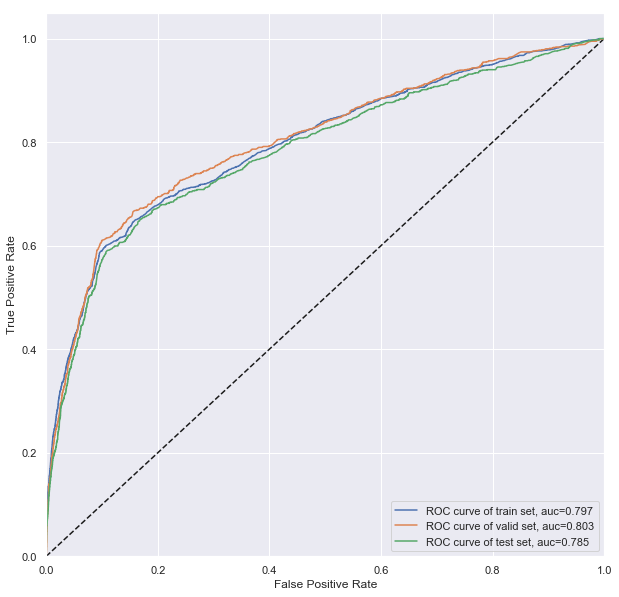

In [24]:
prepare_roc()

fpr, tpr, _ = roc_curve(y_train_dummy, forest.predict_proba(train_dummy)[:,1])
auc=roc_auc_score(y_train_dummy, forest.predict_proba(train_dummy)[:,1])
plt.plot(fpr, tpr, label = 'ROC curve of train set, auc={}'.format(round(auc,3)))
plt.legend(loc="lower right")

fpr, tpr, _ = roc_curve(y_valid_dummy, forest.predict_proba(valid_dummy)[:,1])
auc=roc_auc_score(y_valid_dummy, forest.predict_proba(valid_dummy)[:,1])
plt.plot(fpr, tpr, label = 'ROC curve of valid set, auc={}'.format(round(auc,3)))
plt.legend(loc="lower right")

fpr, tpr, _ = roc_curve(y_test_dummy, forest.predict_proba(test_dummy)[:,1])
auc=roc_auc_score(y_test_dummy, forest.predict_proba(test_dummy)[:,1])
plt.plot(fpr, tpr, label = 'ROC curve of test set, auc={}'.format(round(auc,3)))
plt.legend(loc="lower right")
    

plt.show()

Model seems to be not overfited at all.

Printing variable importance of random forest

Text(0.5, 0, 'Relative Importance')

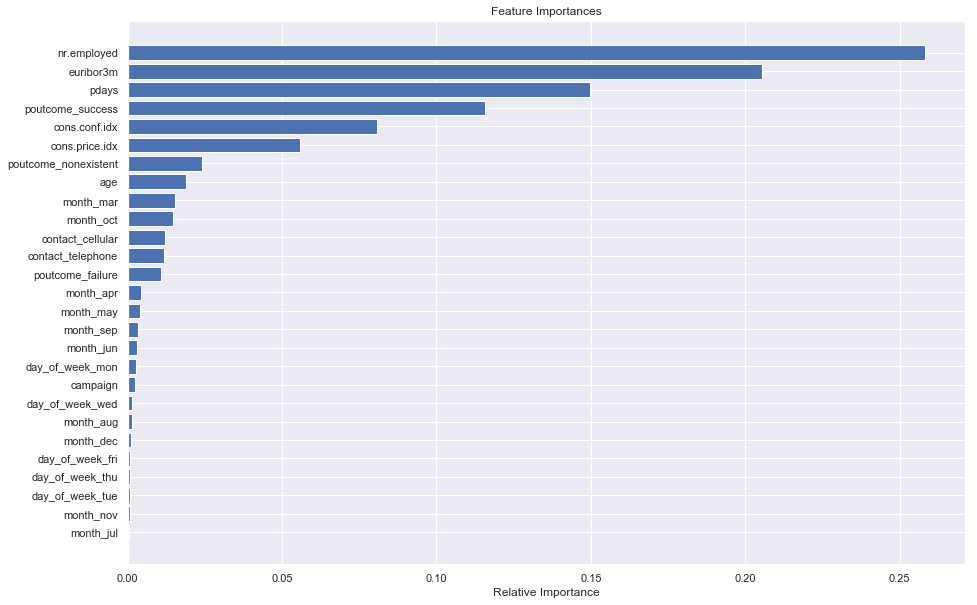

In [26]:
importances = forest.feature_importances_

# then sort them descending
indices = np.argsort(importances)

# get the features from the original data set
features = train_dummy.columns[0:train_dummy.shape[1]]

# plot them with a horizontal bar chart
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

This type of feature importance is similar to importance - gain that we used in LGBM. Most important predictors are the same,
which gives use kind of certainty, that our result are correct and we do not have in our models any fatal mistake.

## Comparison of 2 models.

On test set, LGBM gives AUC of 0.796 which outperforms the performance of random forest's performance on test set, which is 0.785. 
These results are not that surprising. GBM models are usually best performing algorithms in the field of tabular data and are widely used by 
winners of kaggle competitions. 

# Areas for further improvement

If there would be more time for development the first steps I would do with aim to improving the performance of the model.

1. Focus on optimization of hyperparameters. Both LGBM and random forest have large hyperparameter that have impact to the model performance - subsample of row, subsample of columns, number of trees, maximal depth of the trees, minimal number of observations in each node, etc. Optimization of these could improve the performance.

2. Instead of developing single model, developing a k-fold cross-validation model with final prediction as ensemble of those k developed models would bring more robust solution.

3. Focus on some feature engineering and data preprocessing and more careful selection of the variables into final model. 